In [1]:
import cv2
import mediapipe as mp
import numpy as np
import json
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [2]:
mpsolution = mp.solutions.holistic
drawing = mp.solutions.drawing_utils

In [3]:
def Superimpose(image, landmarks):
    drawing.draw_landmarks(image, landmarks.face_landmarks, mpsolution.FACEMESH_CONTOURS, drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1), drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))
    drawing.draw_landmarks(image, landmarks.pose_landmarks, mpsolution.POSE_CONNECTIONS)
    drawing.draw_landmarks(image, landmarks.left_hand_landmarks, mpsolution.HAND_CONNECTIONS, drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1), drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))
    drawing.draw_landmarks(image, landmarks.right_hand_landmarks, mpsolution.HAND_CONNECTIONS, drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1), drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))

In [4]:
def BrightnessContrast(img, brightness = 0, contrast = 0):
     
    # getTrackbarPos returns the current
    # position of the specified trackbar.
    # brightness = cv2.getTrackbarPos('Brightness', 'test')
      
    # contrast = cv2.getTrackbarPos('Contrast', 'test')
  
    effect = controller(img, brightness, contrast)
  
    # The function imshow displays an image
    # in the specified window
    return effect

def controller(img, brightness=255, contrast=127):
    brightness = int((brightness - 0) * (255 - (-255)) / (510 - 0) + (-255))
    contrast = int((contrast - 0) * (127 - (-127)) / (254 - 0) + (-127))
  
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            max = 255
        else:
            shadow = 0
            max = 255 + brightness

        al_pha = (max - shadow) / 255
        ga_mma = shadow
  
        # The function addWeighted calculates
        # the weighted sum of two arrays
        cal = cv2.addWeighted(img, al_pha, img, 0, ga_mma)
    else:
        cal = img
  
    if contrast != 0:
        Alpha = float(131 * (contrast + 127)) / (127 * (131 - contrast))
        Gamma = 127 * (1 - Alpha)  
        # The function addWeighted calculates
        # the weighted sum of two arrays
        cal = cv2.addWeighted(cal, Alpha, cal, 0, Gamma)
  
    # putText renders the specified text string in the image.
    #cv2.putText(cal, 'B:{},C:{}'.format(brightness, contrast), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
  
    return cal

In [5]:
def detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    result = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return result

In [6]:
def Process(result):
    processed = dict()

    if result.pose_landmarks:
        temp = list(result.pose_landmarks.landmark)[0]
        landmarks = np.array([[(res.x - temp.x), (res.y - temp.y), (res.z - temp.z), res.visibility] for res in result.pose_landmarks.landmark])
        # landmarks = np.array([[(res.x), (res.y), (res.z), res.visibility] for res in result.pose_landmarks.landmark])
    else:
        landmarks = np.zeros(33*4)

    processed["pose"] = landmarks.flatten()

    if result.face_landmarks:
        #temp = list(result.face_landmarks.landmark)[0]
        landmarks = np.array([[(res.x - temp.x), (res.y - temp.y), (res.z - temp.z)] for res in result.face_landmarks.landmark])
        # landmarks = np.array([[(res.x), (res.y), (res.z)] for res in result.face_landmarks.landmark])
    else:
        landmarks = np.zeros(468*3)

    processed["face"] = landmarks.flatten()

    if result.right_hand_landmarks:
        #temp = list(result.right_hand_landmarks.landmark)[0]
        landmarks = np.array([[(res.x - temp.x), (res.y - temp.y), (res.z - temp.z)] for res in result.right_hand_landmarks.landmark])
        # landmarks = np.array([[(res.x), (res.y), (res.z)] for res in result.right_hand_landmarks.landmark])
    else:
        landmarks = np.zeros(21*3)

    processed["right_hand"] = landmarks.flatten()

    if result.left_hand_landmarks:
        #temp = list(result.left_hand_landmarks.landmark)[0]
        landmarks = np.array([[(res.x - temp.x), (res.y - temp.y), (res.z - temp.z)] for res in result.left_hand_landmarks.landmark])
        # landmarks = np.array([[(res.x), (res.y), (res.z)] for res in result.left_hand_landmarks.landmark])
    else:
        landmarks = np.zeros(21*3)

    processed["left_hand"] = landmarks.flatten()

    #return processed
    # return np.concatenate([processed["pose"], processed["face"], processed["left_hand"], processed["right_hand"]])
    return processed["pose"]

In [16]:
def DataCollection(path, frames, videos, actions):
    cap = cv2.VideoCapture(0)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')

    for action in actions:
        os.makedirs(os.path.join(path, action))

        for video in range(videos):
            out = cv2.VideoWriter(os.path.join(path, action, "vid%s.avi"%video), fourcc, 25, (640, 480))

            for frame in range(frames):
                ret, image = cap.read()

                if not ret:
                    print(os.path.join(path, action, "vid%s.avi"%video))
                    break
        
                effect = BrightnessContrast(image, 357, 209)

                if frame == 0:
                    cv2.putText(image, "Starting Collection", (120, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.waitKey(1000)

                out.write(effect)
        
                cv2.imshow("OnlyFans!!", effect)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    
    cap.release()
    cv2.destroyAllWindows()

In [17]:
DataCollection("C:\\Users\\kevin\\OneDrive\\Documents\\Year4\\ECNG3020\\Code\\data\\myvids", 50, 3, ["test1", "test2", "test3"])

In [9]:
def run(path, save, time):
    count = 0
    video = cv2.VideoCapture(path)
    cv2.namedWindow('test')
    cv2.createTrackbar('Brightness', 'test', 255, 2 * 255, BrightnessContrast) 
    cv2.createTrackbar('Contrast', 'test', 127, 2 * 127, BrightnessContrast)
    
    with mpsolution.Holistic(min_detection_confidence = 0.5, min_tracking_confidence=0.5) as model:
        while video.isOpened():
            ret, frame = video.read()
            if not ret:
                print(path)
                break
        
            result1 = detection(frame, model)
           # effect = BrightnessContrast(frame, 357, 209)
            #result2 = detection(effect, model)

            Superimpose(frame, result1)
            #Superimpose(effect, result2)
        
            cv2.imshow("OnlyFans!!", frame)
            #cv2.imshow("effect", effect)
            final = Process(result1)
            np.save(save + "/" + str(count), final)
            count += 1

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
    
        video.release()
        cv2.destroyAllWindows()
        return count

video = cv2.VideoCapture(0)
# cv2.namedWindow('test')
# cv2.createTrackbar('Brightness', 'test', 255, 2 * 255, BrightnessContrast) 
# cv2.createTrackbar('Contrast', 'test', 127, 2 * 127, BrightnessContrast)
    
with mpsolution.Holistic(min_detection_confidence = 0.5, min_tracking_confidence=0.5) as model:
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        
        result1 = detection(frame, model)
        effect = BrightnessContrast(frame, 357, 209)
        result2 = detection(effect, model)

        #Superimpose(frame, result1)
        Superimpose(effect, result2)
        
        cv2.imshow("OnlyFans!!", frame)
        cv2.imshow("effect", effect)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    video.release()
    cv2.destroyAllWindows()

In [34]:
with open("missing.txt") as f:
    missing = f.readlines()
    missing = [temp.rstrip("\n") for temp in missing]
    
with open("exercise.json") as f:
    temp = json.load(f)
    data = dict()
    count = 0
    for i in range(len(temp)):
        temp2 = temp[i]["instances"].copy()
        for x in temp[i]["instances"]:
            if missing.count(x["video_id"]) > 0:
                temp2.remove(x)
                count += 1
        data[temp[i]["gloss"]] = [(temp3["video_id"], temp3["frame_start"], temp3["frame_end"]) for temp3 in temp2]


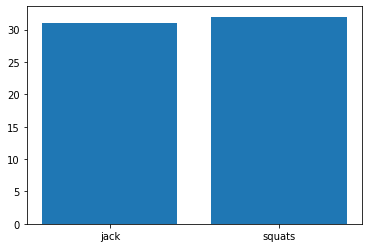

In [35]:
data.keys()
actions = {temp : data[temp] for temp in data}
plt.bar(list(actions.keys()), list(len(temp) for temp in actions.values()), align='center')
plt.xticks(range(len(actions)), list(actions.keys()))

plt.show()


In [58]:
for action in actions:
    os.mkdir("videos/%s"%action)
    for instance in actions[action]:
        os.mkdir("videos/%s/%s"%(action, instance[0]))
        if(os.path.exists("./videos/%s/%s.mp4"%(action, instance[0]))):
            continue
        time = int(1000/instance[1])
        run("C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/%s.mp4"%instance[0], "videos/%s/%s"%(action, instance[0]), time)
    

C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0000.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0001.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0002.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0003.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0004.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0005.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0006.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0007.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0008.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0009.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0010.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0011.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0012.mp4
C:/Users/kevin/OneDrive/D

In [59]:
label_map = {label: num for num, label in enumerate(actions)}
label_map

{'jack': 0, 'squats': 1}

In [60]:
sequences, labels = [], []
for action in actions:
    for video in actions[action]:
        temp = []
        for filename in os.listdir("videos/%s/%s"%(action, video[0])):
            frame = np.load("videos/%s/%s/%s"%(action, video[0], filename))
            if len(frame) != 33*4:
                print("ERROR IN videos/%s/%s/%s"%(action, video[0], filename))
            temp.append(frame)
        sequences.append(temp)
        labels.append(label_map[action])


In [61]:
type(actions["jack"])

list

In [62]:
full = max([len(i) for i in sequences])
for vid in sequences:
    if len(vid) < full:
        for i in range(full - len(vid)):
            vid.append(np.zeros(33*4))

In [63]:
x = np.array(sequences)
y = to_categorical(labels).astype(int)

In [64]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05)

In [65]:
x_train.shape

(59, 284, 132)

In [71]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [72]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(284, 132)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [73]:
model.fit(x_train, y_train, epochs=350, batch_size=5, callbacks=[tb_callback])

Epoch 1/350
12/12 [==============================] - 47s 4s/step - loss: 0.6945 - categorical_accuracy: 0.4746
Epoch 2/350
12/12 [==============================] - 44s 4s/step - loss: 741533.6875 - categorical_accuracy: 0.5932
Epoch 3/350
 3/12 [======>.......................] - ETA: 31s - loss: nan - categorical_accuracy: 0.6000          

KeyboardInterrupt: 